# Visualisation de payoff de stratégie d'option

On souhaite visualiser les éventuels profits d'une stratégie d'options composées de call et put européen. Pour ce faire, on veut un système souple qui nous permet d'écrire n'importe quelle stratégie d'options et obtenir un visuel clair et auto-suffisant.

Pour illustrer les graphiques, nous exploiterons les données de marché. L'objectif n'est pas de faire une séance parfaite au niveau financier, mais travailler la programmation en général et la conception d'une visualisation claire.

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')

Pour travailler ce sujet, il nous faut un plan clair avant de commencer à écrire une première ligne de code.


## Réflexions de préparations

Nous devons avoir une **structure de donnée** claire pour stocker et exploiter les informations des différents options consistuant la stratégie d'option.
Dans un deuxième temps nous devons être capable de **traduire** de cette structure de donnée à un payoff de manière efficace et réexploitable.
Finalement, il nous faut avoir une **visualisation** très claire avec l'essentiel des informations affichées.


### Structure de donnée
Pour définir les options que l'on considère il nous faut que quatres informations :
1. S'il s'agit d'un call ou d'un put
2. Si nous achetons ou vendons l'action
3. Le strike de l'option
4. Le premium de l'option

Le mieux pour la lisibilité est d'exploiter un dictionnaire ici. Le premium de l'option ne sera pas renseigné parce que nous ne le connaissons pas forcément à l'avance, donc nous irons le récupérer à la volée.


### Traduction
Nous avons besoin de définir tout un ensemble de fonction de payoff qui seront toute différentes selon les quatres points précédent. Mais nous pouvons exploiter les fonctions anonymes *lambda* pour renvoyer une fonction déjà calibrée pour chacune des options.
De cette manière, chaque option est traduite en une fonction payoff que l'on peut exploiter sur l'ensemble des prix possible.


### Visualisation
En ayant une bijection option/fonction, nous pouvons sommer les résultats sur un axe de prix cohérent pour obtenir la visualisation de la stratégie finale.


Nous avons donc notre plan de manière quasiment détaillée, il restera à régler plusieurs points d'ordre technique dans l'ensemble des fonctions. Commençons par définir notre première stratégie d'option.

In [2]:
operation_1 = {'type': 'put', 'side': 'buy', 'strike': 3290}
operation_2 = {'type': 'call', 'side': 'buy', 'strike': 3290}

operations = [operation_1, operation_2]

Il nous faut être capable de faire la traduction entre ces informations et une fonction. Nous proposons la manière suivante :

In [3]:
def call(strike, premium=0, side="buy"):
    call_function = lambda x: (np.maximum(0, x - strike) - premium) * (1 if side == "buy" else -1)
    return call_function



def put(strike, premium=0, side="buy"):
    put_function = lambda x: (np.maximum(0, strike - x) - premium) * (1 if side == "buy" else -1)
    return put_function

Avec ce choix nous pouvons facilement tracer des graphiques :

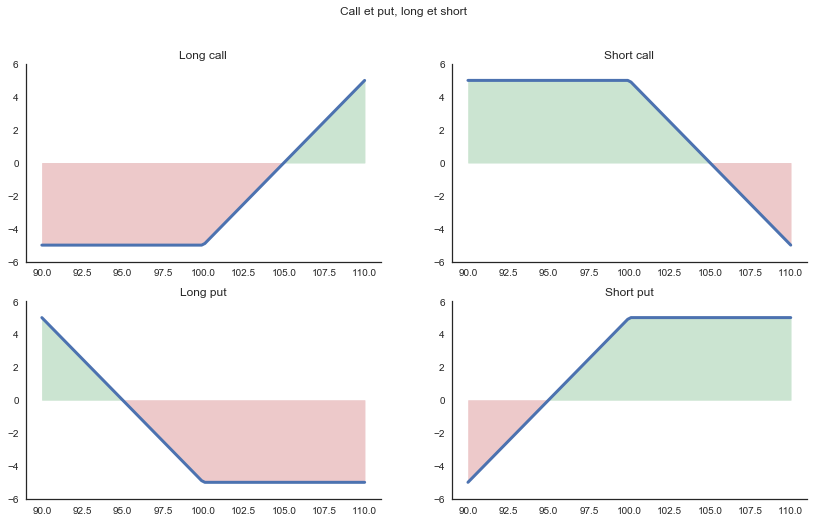

In [4]:
strike = 100
premium = 5
prices = np.linspace(90, 110, 100)

plt.figure(figsize=(14, 8))
index = 1




for function in [call, put]:
    for side in ['buy', 'sell']:
        payoff = function(strike=strike, premium=premium, side=side)
        payoff_value = payoff(prices)
        
        
        plt.subplot(2, 2, index)
        plt.plot(prices, payoff_value, lw=3)
        plt.fill_between(prices, payoff_value, 0, where=(payoff_value < 0), alpha=0.30, color=sns.color_palette()[2], interpolate=True)
        plt.fill_between(prices, payoff_value, 0, where=(payoff_value >= 0), alpha=0.30, color=sns.color_palette()[1], interpolate=True)
        
        plt.ylim(-6, 6)
        title = ("Long " if side == 'buy' else "Short ") + function.__name__
        plt.title(title)
        sns.despine()
        
        
        index += 1

        


plt.suptitle("Call et put, long et short")
plt.show()

Nous avons une structure de donnée et la capacité de présenter des payoffs d'options simple. Avant de passer à la fonction générale, nous souhaitons extraires les informations générale du marché pour un stock donné.

In [5]:
def extract_market_informations(ticker_name, expiration_date):
    ticker = yf.Ticker(ticker_name)
    
    options = ticker.option_chain(expiration_date)
    calls = options.calls[["strike", "lastPrice"]]
    puts = options.puts[["strike", "lastPrice"]]
    
    last_historic = ticker.history(period='1d', interval='5m')
    actual_price = float(last_historic["Open"].tail(1))
    
    return {'calls': calls, 'puts': puts, 'current_price': actual_price}

Nous pouvons à présent écrire une grande fonction de visualisation. On souhaite voir :
* Quand la stratégie est gagnante
* Quel mouvement est nécessaire avant un changement de statut (gain/perte)
* Le prix actuel

In [9]:
def payoff_visualisation(ticker_name, operations, expiration_date, alpha=0.1):
    ticker = extract_market_informations(ticker_name, expiration_date)
    strikes = [operation["strike"] for operation in operations]
    values = np.linspace(start=min(strikes)*(1-alpha), stop=max(strikes)*(1+alpha), num=500)
    strategie = np.zeros(shape=len(values))
    
    
    
    
    for operation in operations:
        if operation["type"] == "call":
            premium = float(ticker["calls"].loc[ticker["calls"]["strike"] == operation["strike"], "lastPrice"])
            function = call(operation["strike"], premium=premium, side=operation["side"])
        if operation["type"] == "put":
            premium = float(ticker["puts"].loc[ticker["puts"]["strike"] == operation["strike"], "lastPrice"])
            function = put(operation["strike"], premium=premium, side=operation["side"])
        
        label = ("Long " if operation["side"] == "buy" else "Short ") + operation["type"] + ", strike=" + str(operation["strike"])
        plt.plot(values, function(values), label=label, alpha=0.8)
        strategie = strategie + function(values)
    
    
    
    
    plt.axvline(x=ticker["current_price"], c="black", alpha=0.3, ls='--', label="Spot")
    title = "Option strategy (" + ticker_name + "), Exp: " + expiration_date
    plt.plot(values, strategie, label="Strategy", lw=4)
    
    
    plt.fill_between(values, strategie, 0, where=(strategie < 0), alpha=0.30, color=sns.color_palette()[2], interpolate=True)
    plt.fill_between(values, strategie, 0, where=(strategie >= 0), alpha=0.30, color=sns.color_palette()[1], interpolate=True)
    
    
    rule = strategie[:-1] * strategie[1:]
    break_evens = values[np.concatenate((rule, np.array([0]))) < 0].astype(int)
    plt.plot(break_evens, [0]*len(break_evens), 'o', c="black")
    for point in break_evens:
        movement = round(100 * (point / ticker["current_price"] - 1), 2)
        string = ("+" if movement >= 0 else "-") + str(movement) + "%"
        plt.annotate(string, xy=(point, 0), xytext=(point, 0.03 * (max(strategie) - min(strategie))))
    
    
    
    
    sns.despine()
    plt.title(title)
    plt.xlabel("Stock Price")
    plt.ylabel("Loss / Profit")
    plt.legend()
    plt.show()

On a sur un exemple :

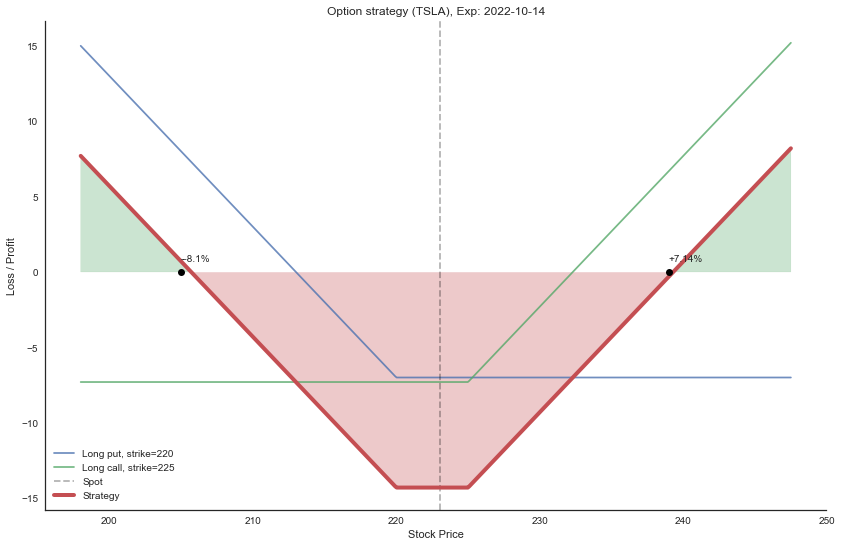

In [10]:
operation_1 = {'type': 'put', 'strike': 220, 'side': 'buy'}
operation_2 = {'type': 'call', 'strike': 225, 'side': 'buy'}
plt.figure(figsize=(14, 9))
payoff_visualisation("TSLA", [operation_1, operation_2], "2022-10-14")